In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data['boolQuality'] = 0
data['boolQuality'][data['quality']>5] = 1

C:\Users\Derrick\AppData\Local\Temp\ipykernel_9700\1367583247.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>5] = 1


In [3]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

In [4]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)


# train and test dataloaders
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=True, drop_last=True)

In [5]:
class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(11,16)

        self.fc1 = nn.Linear(16,32)
        self.bnorm1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(32,20)
        self.bnorm2 = nn.BatchNorm1d(32)

        self.output = nn.Linear(20,1)
    
    def forward(self, x, doBN):
        x = F.relu(self.input(x))
        if doBN:
            x = self.bnorm1(x)
            x = self.fc1(x)
            x = F.relu(x)

            x = self.bnorm2(x)
            x = self.fc2(x)
            x = F.relu(x)
        
        else:
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
        
        return self.output(x)

In [9]:
epochs = 1000

def train_model(model, doBN=True):
    loss_fun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=.01)

    losses = torch.zeros(epochs)
    train_acc = []
    test_acc = []

    for i in range(epochs):
        model.train()
        batch_loss = []
        batch_acc = []
        for X, y in train_loader:
            y_hat = model(X, doBN)
            loss = loss_fun(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())
            batch_acc.append(100*torch.mean(((y_hat>0)==y).float()).item())
        
        train_acc.append(np.mean(batch_acc))
        losses[i] = np.mean(batch_loss)

        model.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            y_hat = model(X, doBN)
        test_acc.append(100*torch.mean(((y_hat>0)==y).float()).item())
    return train_acc, test_acc, losses




In [10]:
model = ANNwine()
train_acc_no, test_acc_no, losses_no = train_model(model, False)

model = ANNwine()
train_acc_with, test_acc_with, losses_with = train_model(model, True)

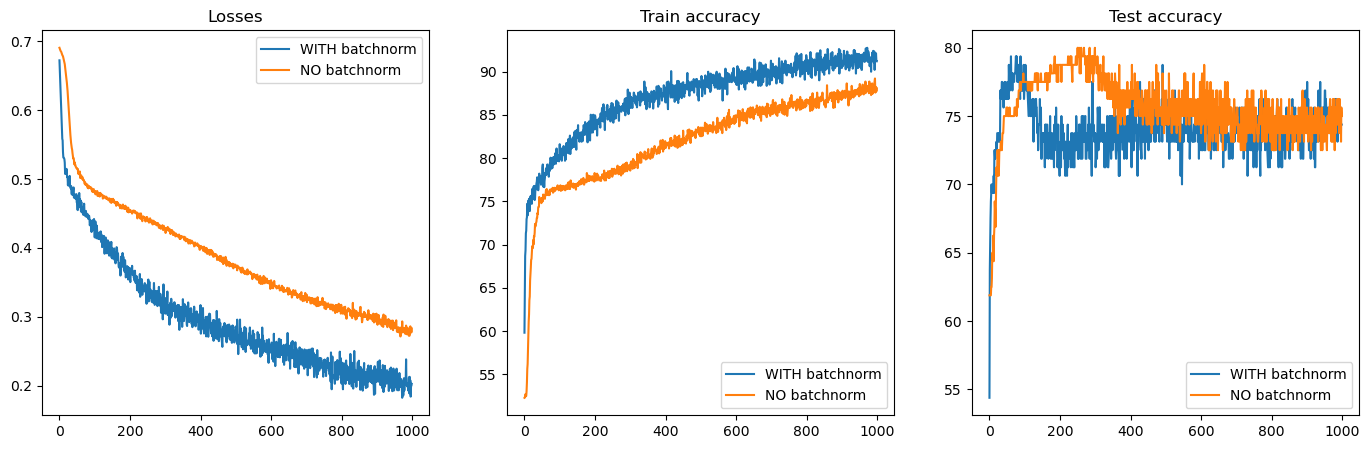

In [11]:
# plot the results
fig,ax = plt.subplots(1,3,figsize=(17,5))

ax[0].plot(losses_with,label='WITH batchnorm')
ax[0].plot(losses_no,label='NO batchnorm')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(train_acc_with,label='WITH batchnorm')
ax[1].plot(train_acc_no,label='NO batchnorm')
ax[1].set_title('Train accuracy')
ax[1].legend()

ax[2].plot(test_acc_with,label='WITH batchnorm')
ax[2].plot(test_acc_no,label='NO batchnorm')
ax[2].set_title('Test accuracy')
ax[2].legend()

plt.show()

In [12]:
model = ANNwine()
train_acc_no, test_acc_no, losses_no = train_model(model, False)

model = ANNwine()
train_acc_with, test_acc_with, losses_with = train_model(model, True)

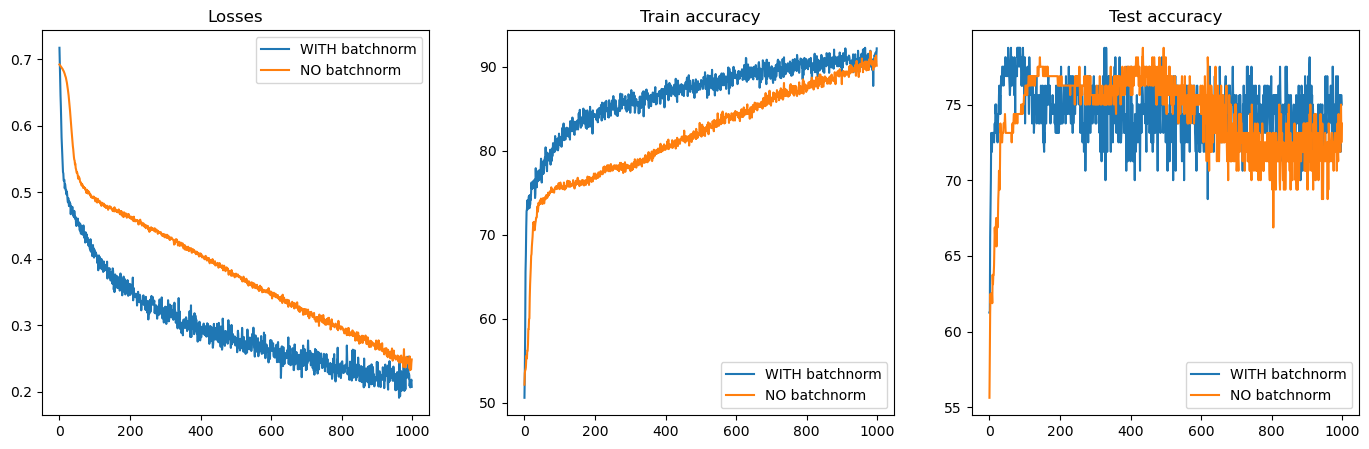

In [13]:
# plot the results
fig,ax = plt.subplots(1,3,figsize=(17,5))

ax[0].plot(losses_with,label='WITH batchnorm')
ax[0].plot(losses_no,label='NO batchnorm')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(train_acc_with,label='WITH batchnorm')
ax[1].plot(train_acc_no,label='NO batchnorm')
ax[1].set_title('Train accuracy')
ax[1].legend()

ax[2].plot(test_acc_with,label='WITH batchnorm')
ax[2].plot(test_acc_no,label='NO batchnorm')
ax[2].set_title('Test accuracy')
ax[2].legend()

plt.show()